## Set up Google Colab environment

In [1]:
### Set colaboratory True to run in Google Colaboratory. 
colab = True

if colab:
  from google.colab import drive
  drive.mount('/content/drive')
  import os
  ## Specify a directory in Google Drive
  dir = '/content/drive/My Drive/Colab Notebooks/Keras_MNIST'
  os.chdir(dir)
  #os.getcwd()
  #os.listdir()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
if colab:
  ## Check the uptime. (Google Colab reboots every 12 hours)
  !cat /proc/uptime | awk '{print "Uptime is " $1 /60 /60 " hours (" $1 " sec)"}'
  ## Check the GPU info
  !nvidia-smi
  ## Check the Python version
  !python --version

Uptime is 1.1329 hours (4078.45 sec)
Sat Jan 26 05:43:51 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                       

## Import modules

In [3]:
import os
import glob
import numpy as np
import pandas as pd
from IPython.display import display

import tensorflow as tf
from tensorflow import keras

tf.__version__

'1.12.0'

## Set up data

In [4]:
## Set up data to use CNN

mnist = keras.datasets.mnist
# More dataset choices here: https://www.tensorflow.org/api_docs/python/tf/keras/datasets
# input image dimensions
img_x, img_y = 28, 28

# Load training data, labels; and testing data and their true labels
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# because the MNIST is greyscale, we only have a single channel - RGB colour images would have 3
x_train = x_train.reshape(x_train.shape[0], img_x, img_y, 1)
x_test  = x_test.reshape(x_test.shape[0], img_x, img_y, 1)
input_shape = (img_x, img_y, 1)

# Normalize input between 0 and 1
# Very important
x_train = x_train / 255.0
x_test = x_test / 255.0

# Check shapes of x_train, y_train etc
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28, 1)
(60000,)


## Define model

In [5]:
# We will use a sequential model https://keras.io/getting-started/sequential-model-guide/
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, Dropout 
from keras.optimizers import Adam, Adadelta

def create_model(input_shape):
  model = Sequential()
  model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1),
                   activation='relu',
                   input_shape=input_shape))
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='softmax'))
  
  # Compile the model with appropriate Loss function
  model.compile(optimizer=Adam(), 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

Using TensorFlow backend.


## Fit model

In [6]:
### If resume_if_possible = True, fitting can resume using a model file. 
resume_if_possible = True 

### Set resume_if_possible = False to force fitting from scratch.
#resume_if_possible = False 

epochs = 100
batch_size = 64
log_file_path = 'training_log.csv'
model_file_path = 'model_epoch{epoch:06d}.hdf5'

model_file_list = glob.glob('model_epoch*.hdf5')
log_file_list = glob.glob(log_file_path)

if resume_if_possible:
  resume_flag = (len(model_file_list) >= 1) 
  
if not resume_if_possible:
  resume_flag = False
  for f in model_file_list:
    os.remove(f)

if resume_flag:
  latest_model_file = model_file_list[-1]
  latest_epoch = int(latest_model_file[len('model_epoch'):-len('.hdf5')])
  ## Load the saved model
  model = keras.models.load_model(latest_model_file)

  score = model.evaluate(x_test,y_test, verbose=0)
  print('Use {} to resume fitting. \nTest loss: {}   Test accuracy: {}'.format(latest_model_file, score[0], score[1]))

  if len(model_file_list) >= 2:
    ## Delete all model files excpet the latest to save space
    for f in model_file_list[:-1]:
      os.remove(f)

if not resume_flag:
  latest_epoch = 0
  ## Create a basic model instance
  model = create_model(input_shape)
  for f in log_file_list:
    os.remove(f)

model.summary()

## Create checkpoint callback
check_point_ = tf.keras.callbacks.ModelCheckpoint(filepath = model_file_path, 
                                                 monitor = 'val_acc',
                                                 verbose=1,
                                                 save_best_only = True,
                                                 mode='auto',
                                                 save_weights_only=False,
                                                 period = 1)

## Create early stopping callback
early_stopping_ = tf.keras.callbacks.EarlyStopping(monitor='val_acc', 
                                                   min_delta=0, 
                                                   patience=5, 
                                                   verbose=1, 
                                                   mode='auto', 
                                                   baseline=None)

## Create CSV logger callback
csv_logger_ = tf.keras.callbacks.CSVLogger(filename = log_file_path, separator=',',
                                           append = resume_flag)

## Fit 
model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, initial_epoch = latest_epoch,
          validation_data = (x_test,y_test), shuffle = True,
          callbacks = [check_point_, early_stopping_, csv_logger_])

## Remove duplicates as save_best_only option of checkpoint is set to True.
pd.options.display.max_rows = 8
log_df = pd.read_csv(log_file_path)
log_wo_dup_df = log_df.drop_duplicates(subset = ['epoch'], keep='last').reset_index(drop=True)
log_wo_dup_df.to_csv((log_file_path[:-len('.csv')] + '_processed.csv'), index=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 512)       5120      
_________________________________________________________________
flatten_1 (Flatten)          (None, 346112)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 346112)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3461130   
Total params: 3,466,250
Trainable params: 3,466,250
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 44s 732us/step - loss: 0.1456 - acc: 0.9568 - val_loss: 0.0646 - val_acc: 0.9790

Epoch 00001: val_acc improved from -inf to 0.97900, saving model to model

In [0]:
### Clean up
model_file_list = glob.glob('model_epoch*.hdf5')  
if len(model_file_list) >= 2:
  ## Delete all model files excpet the latest one to save space
  for f in model_file_list[:-1]:
    os.remove(f)

,epoch,acc,loss,val_acc,val_loss
0,0,0.956783,0.145552,0.9790,0.064596
1,1,0.981667,0.058787,0.9792,0.062727
2,2,0.988017,0.039126,0.9812,0.063878
3,3,0.991000,0.028703,0.9766,0.078544
...,...,...,...,...,...
7,7,0.995900,0.012276,0.9819,0.075280
8,8,0.996450,0.009894,0.9802,0.091460
9,9,0.997000,0.009431,0.9814,0.080487
10,10,0.997283,0.007944,0.9822,0.080183


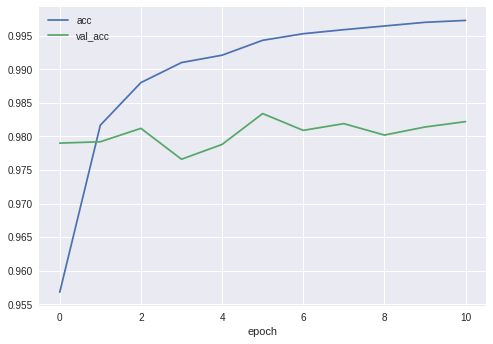

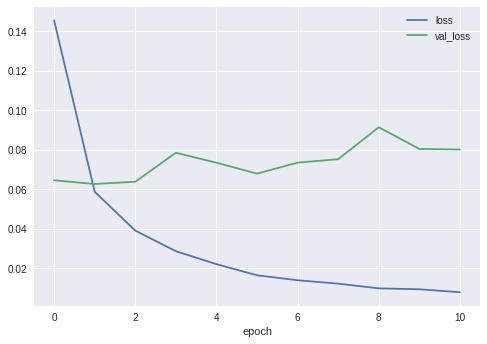

In [8]:
display(log_wo_dup_df)
log_wo_dup_df[['epoch', 'acc', 'val_acc']].plot(x='epoch')
log_wo_dup_df[['epoch', 'loss', 'val_loss']].plot(x='epoch')

References:


https://keras.io/callbacks/

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint